# Project: Investigate the No-Show database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset chosen for analysis is the 'No-Show appointments' dataset from Kaggle, which contains statistics on how many patients fail to show up for their medical appointments along with other characteristics such as the day the appointment was scheduled, the neighbourhood of the patient, alcoholism etc.

The purpose of the analysis is to identify the factors that correlate the most with patients making it or missing their appointments, with the goal of bolstering the ratio of patients making it to their appointments.

At the outset, it appears that sending SMS reminders and providing the Scholarship/Financial Aid `Bolsa Familia` are two ways in which patients could be encouraged to not miss their appointments, so we would want to test to see if these do indeed improve the ratio of show/no-show.

For instance, for cases where the appointment day was much later than the scheduled day, SMS alerts could be crucial go ensuring appointments are honoured by the patients.

The dependent variable we are looking at is the `no_show` statistic, and the independent variables are those related to patient demographics such as `age`, `gender` etc and health factors such as `diabetes`, `hypertension` and other factors related to appointment scheduling such as `scheduled_time_frame`, `appointment_day_of_week` and `sms_received`. 

To summarize this in terms of Research questions, we would want to ask the following questions-  
1) What are the factors that most correlate with an appointment ending up as show/no-show? We look at the patient demographics and circumstances of the appointment scheduling such as the time to appointment from scheduling, and drill down to answer the following specifics-  
    1a) Are appointment scheduled nearer in the future more likely to be honored?   
    1b) Are appointments that fall on certain days of the week less likely to be honored?    
    1c) Patients of which gender are more likely to keep the appointment?  
    1d) Patients of which age-group are more likely to keep the appointment?  
    1e) Which health condition impedes the chances of keeping the appointment?  
2) Do SMS reminders help increase the chances of patients showing up for appointment?    
2a) Do SMS reminders improve the odds for patients who made their appointments much earlier than the date of appointments?  
2b) Do SMS reminders improve the odds for older patients?  
3) Does Bolsa Familia enrollment have a correlation with the ratio of show/no-show?   

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='wrangling'></a>
## Data Wrangling

### Inspecting Properties and Data Cleaning

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('NoShow/noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

#### Fixing name, datatype, missing data and duplicates

We notice that the column names are inconsistent in their formatting. Most of them are in camel-case, whereas `SMS_received` follows underscore convention, and `No-show` is hyphen separated. The word `id` is formatted differently between `PatientId`  and `AppointmentID`. We can move all the names to snake-case for sake of consistency. Also, we will fix the spelling mistake in `Handcap` and `Hipertension` when we rename.

In [4]:
df.rename(columns={'PatientId' : 'patient_id', 'AppointmentID' : 'appointment_id', 
                   'ScheduledDay' : 'scheduled_day', 'AppointmentDay' : 'appointment_day', 
                   'Hipertension' : 'hypertension', 'Handcap' : 'handicap', 'No-show' : 'no_show' }, inplace=True)

In [5]:
df.rename(columns=lambda x: x.strip().lower(), inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null float64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null object
appointment_day    110527 non-null object
age                110527 non-null int64
neighbourhood      110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [7]:
df.shape

(110527, 14)

We note that there are 14 columns and 110527 appointment entries and it appears that there are no null values.We also confirm this with the isnull query below.

In [8]:
df.isnull().sum()

patient_id         0
appointment_id     0
gender             0
scheduled_day      0
appointment_day    0
age                0
neighbourhood      0
scholarship        0
hypertension       0
diabetes           0
alcoholism         0
handicap           0
sms_received       0
no_show            0
dtype: int64

We now look for duplicates, and the number of unique entries per column.

In [9]:
sum(df.duplicated())

0

In [10]:
df.nunique()

patient_id          62299
appointment_id     110527
gender                  2
scheduled_day      103549
appointment_day        27
age                   104
neighbourhood          81
scholarship             2
hypertension            2
diabetes                2
alcoholism              2
handicap                5
sms_received            2
no_show                 2
dtype: int64

No de-duping is necessary as there seem to be no duplicate entries. We do notice however that the number of unique appointment_ids equals the number of records, so each entry in the appointment dataset seems to be identifiable uniquely. The dtype of appointment_id is also an int64, so we can safely make appointment_id the index for this dataframe.

In [11]:
df.set_index('appointment_id', inplace=True)
df.head()

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
appointment_id,,,,,,,,,,,,,
5642903,2.987250e+13,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
5642503,5.589978e+14,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
5642549,4.262962e+12,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
5642828,8.679512e+11,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
5642494,8.841186e+12,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Now, we inspect every column data and convert it to the appropriate data type

##### patient_id

We would have expected patient_id to be an int, but its stored as a float instead. Let's first check to see how many of the entries actually have decimal points.

In [12]:
df.shape[0] - sum(df['patient_id'].apply(lambda x: x.is_integer()))

5

Since this is a small enough number, we can look at all of these entries to see what's unique to them to warrent decimal points.

In [13]:
df[~df['patient_id'].apply(lambda x: x.is_integer())]

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
appointment_id,,,,,,,,,,,,,
5712759,93779.52927,F,2016-05-18T09:12:29Z,2016-05-18T00:00:00Z,33,CENTRO,0,0,0,0,0,0,No
5637728,537615.28476,F,2016-04-29T07:19:57Z,2016-05-06T00:00:00Z,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No
5637648,141724.16655,M,2016-04-29T07:13:36Z,2016-05-02T00:00:00Z,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No
5751990,39217.84439,F,2016-05-31T10:56:41Z,2016-06-03T00:00:00Z,44,PRAIA DO SUÁ,0,0,0,0,0,0,No
5760144,43741.75652,M,2016-06-01T14:22:58Z,2016-06-01T00:00:00Z,39,MARIA ORTIZ,0,0,1,0,0,0,No


We see that all the five datapoints have 5 values after the decimal place and 5-6 values before the decimal place. Apart from this, there appears to be no correlation between these five values interms of day of scheduling/appointment, gender or location of patient. We can check the number of digits in other datapoints to compare against this.

In [14]:
df['patient_id'].apply(lambda x: len(str(int(x)))).value_counts()

14    39372
13    28319
15    24919
12    12835
11     4002
10      920
9       136
8        18
5         3
6         2
7         1
Name: patient_id, dtype: int64

This data is inconclusive since it doesn't indicate how these five cases are different from other patient_ids since there are a few variations in patient_ids with respect to the number of digits. Hence, we keep this as float since this field won't be used for anything other than as identifier for individual patients.

##### gender

In [15]:
df['gender'].value_counts()

F    71840
M    38687
Name: gender, dtype: int64

We can conver this categorical data with two categories, to boolean for easy query in the future.

In [16]:
df['is_female'] = df['gender'] == 'F'
df.drop(columns='gender', inplace=True)

In [17]:
df['is_female'].value_counts()

True     71840
False    38687
Name: is_female, dtype: int64

##### scheduled_day and appointment day

We notice that the appointment day always show the time as 00:00:00. So we can drop the time from the scheduled day also. Both of these can now be converted from object to datetime.date. Before doing this, we might want to extract the day of the week, since appointments that fall on certain days of the week, could possibly have a higher chance of no-shows and this might be worth investigating.

In [18]:
df['appointment_day_of_week'] = pd.to_datetime(df['appointment_day']).dt.weekday
df['appointment_day'] = pd.to_datetime(df['appointment_day']).dt.date
df['scheduled_day'] = pd.to_datetime(df['scheduled_day']).dt.date


Another metric that might be useful to know is the number of days between the day of appointment and the day the appointment was scheduled, since longer gap could possibly lead to patients not needing and forgetting to cancel the appointment, or forgetting about the date of appointment altogether

In [19]:
df['days_scheduled_in_advance'] = (df['appointment_day'] - df['scheduled_day']).astype('timedelta64[D]')

In [20]:
df['days_scheduled_in_advance'].describe()

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: days_scheduled_in_advance, dtype: float64

Since there are some negative values here, we'll investigate to see why that might be the case.

In [21]:
df.query('days_scheduled_in_advance < 0')

,patient_id,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,is_female,appointment_day_of_week,days_scheduled_in_advance
appointment_id,,,,,,,,,,,,,,,
5679978,7.839273e+12,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,False,0,-1.0
5715660,7.896294e+12,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,True,1,-1.0
5664962,2.425226e+13,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,True,2,-1.0
5686628,9.982316e+14,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,True,3,-6.0
5655637,3.787482e+12,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,False,1,-1.0


There is no pattern or commonality in terms of patient_id or date of scheduling or appointment. Since the number of these datapoints is small compared to overall dataset, we can just leave these in there.

In [22]:
df['days_scheduled_in_advance'].nunique()

131

However we see that the number of unique days_scheduled_in_advance is quite high, so we will create new categories to group these into, for manageability. We see that the 25th percentile falls at same day appointments, so the first group would consist of same day appointments. Appointments made within four days fall at the 50% percentile and appointments made within 15 days fall at the 75th percentile. So, we could create three new groups  to capture appointments scheduled within same week, within same month and beyond that.

In [23]:
bin_edges = [-6, 0, 1, 8, 32, 180]
bin_names=['na', 'same_day', 'same_week', 'same_month', 'long_term']
df['scheduled_time_frame'] = pd.cut(df['days_scheduled_in_advance'], bin_edges, labels=bin_names, right=False)

In [24]:
df['scheduled_time_frame'].value_counts()

same_day      38563
same_week     32185
same_month    30068
long_term      9706
na                5
Name: scheduled_time_frame, dtype: int64

In [25]:
df['appointment_day_of_week'].value_counts()

2    25867
1    25640
0    22715
4    19019
3    17247
5       39
Name: appointment_day_of_week, dtype: int64

##### scholarship, hypertension, diabetes, alcoholism, handicap, sms_received

In [26]:
for col in ['scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received']:
    print(df[col].unique())

[0 1]
[1 0]
[0 1]
[0 1]
[0 1 2 3 4]
[0 1]


Convert all the two category columns ( exclude `handicap` ) to boolean.

In [27]:
for col in ['scholarship', 'hypertension', 'diabetes', 'alcoholism', 'sms_received']:
    df[col] = df[col].astype(bool)

##### no_show

Again this can be converted to boolean from yes/no

In [28]:
df['no_show'].unique()

array(['No', 'Yes'], dtype=object)

In [29]:
df['no_show'].value_counts()

No     88208
Yes    22319
Name: no_show, dtype: int64

In [30]:
df['no_show'] = df['no_show'].apply(lambda x: x == 'Yes')

In [31]:
df['no_show'].value_counts()

False    88208
True     22319
Name: no_show, dtype: int64

In [32]:
df.head()

,patient_id,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,is_female,appointment_day_of_week,days_scheduled_in_advance,scheduled_time_frame
appointment_id,,,,,,,,,,,,,,,,
5642903,2.987250e+13,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,0,False,False,True,4,0.0,same_day
5642503,5.589978e+14,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,0,False,False,False,4,0.0,same_day
5642549,4.262962e+12,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,0,False,False,True,4,0.0,same_day
5642828,8.679512e+11,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,0,False,False,True,4,0.0,same_day
5642494,8.841186e+12,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,0,False,False,True,4,0.0,same_day


#### Data consistency
Now, we can check for consistency of the actual dataset using summary statistics

In [33]:
df.describe()

,patient_id,age,handicap,appointment_day_of_week,days_scheduled_in_advance
count,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,37.088874,0.022248,1.858243,10.183702
std,2.560949e+14,23.110205,0.161543,1.371672,15.254996
min,3.921784e+04,-1.000000,0.000000,0.000000,-6.000000
25%,4.172614e+12,18.000000,0.000000,1.000000,0.000000
50%,3.173184e+13,37.000000,0.000000,2.000000,4.000000
75%,9.439172e+13,55.000000,0.000000,3.000000,15.000000
max,9.999816e+14,115.000000,4.000000,5.000000,179.000000


##### age

The oldest patient is 115 days old, and the lowest age is shown as -1.

In [34]:
df.query('age == -1')

,patient_id,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,is_female,appointment_day_of_week,days_scheduled_in_advance,scheduled_time_frame
appointment_id,,,,,,,,,,,,,,,,
5775010,4.659432e+14,2016-06-06,2016-06-06,-1,ROMÃO,False,False,False,False,0,False,False,True,0,0.0,same_day


In [35]:
df.query('age == 115')

,patient_id,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,is_female,appointment_day_of_week,days_scheduled_in_advance,scheduled_time_frame
appointment_id,,,,,,,,,,,,,,,,
5700278,3.196321e+13,2016-05-16,2016-05-19,115,ANDORINHAS,False,False,False,False,1,False,True,True,3,3.0,same_week
5700279,3.196321e+13,2016-05-16,2016-05-19,115,ANDORINHAS,False,False,False,False,1,False,True,True,3,3.0,same_week
5562812,3.196321e+13,2016-04-08,2016-05-16,115,ANDORINHAS,False,False,False,False,1,False,True,True,0,38.0,long_term
5744037,3.196321e+13,2016-05-30,2016-05-30,115,ANDORINHAS,False,False,False,False,1,False,False,True,0,0.0,same_day
5717451,7.482346e+14,2016-05-19,2016-06-03,115,SÃO JOSÉ,False,True,False,False,0,True,False,True,4,15.0,same_month


In [36]:
df.query('age == 115')['patient_id'].nunique()

2

In [37]:
bin_edges = [-1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 115]
bin_names = ['Below Zero', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', 'Above 100']
df['age_group'] = pd.cut(df['age'], bin_edges, labels=bin_names, right=False)

In [38]:
df['age_group'].value_counts()

0-10          17475
50-60         15863
30-40         15171
40-50         14209
20-30         13699
10-20         12936
60-70         11876
70-80          5934
80-90          2946
90-100          406
Above 100         6
Below Zero        1
Name: age_group, dtype: int64

There is exactly one patient with age -1, and two patients with age 115. These values appear odd and are possibly data entry errors. However, these three patients account for a total of 6 appointments out of the total 110527 appointments so we will keep them, since they're not high enough to skew the results of our analysis. The age distribution across appointments looks sane overall and indicates that appointments are spread out quite well for every 10 year age group upto 70 years of age.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5642903 to 5629448
Data columns (total 17 columns):
patient_id                   110527 non-null float64
scheduled_day                110527 non-null object
appointment_day              110527 non-null object
age                          110527 non-null int64
neighbourhood                110527 non-null object
scholarship                  110527 non-null bool
hypertension                 110527 non-null bool
diabetes                     110527 non-null bool
alcoholism                   110527 non-null bool
handicap                     110527 non-null int64
sms_received                 110527 non-null bool
no_show                      110527 non-null bool
is_female                    110527 non-null bool
appointment_day_of_week      110527 non-null int64
days_scheduled_in_advance    110527 non-null float64
scheduled_time_frame         110527 non-null category
age_group                    110522 non-null category
dtypes: b

<a id='eda'></a>
## Exploratory Data Analysis



Let's look at the distribution of our columns to begin with.

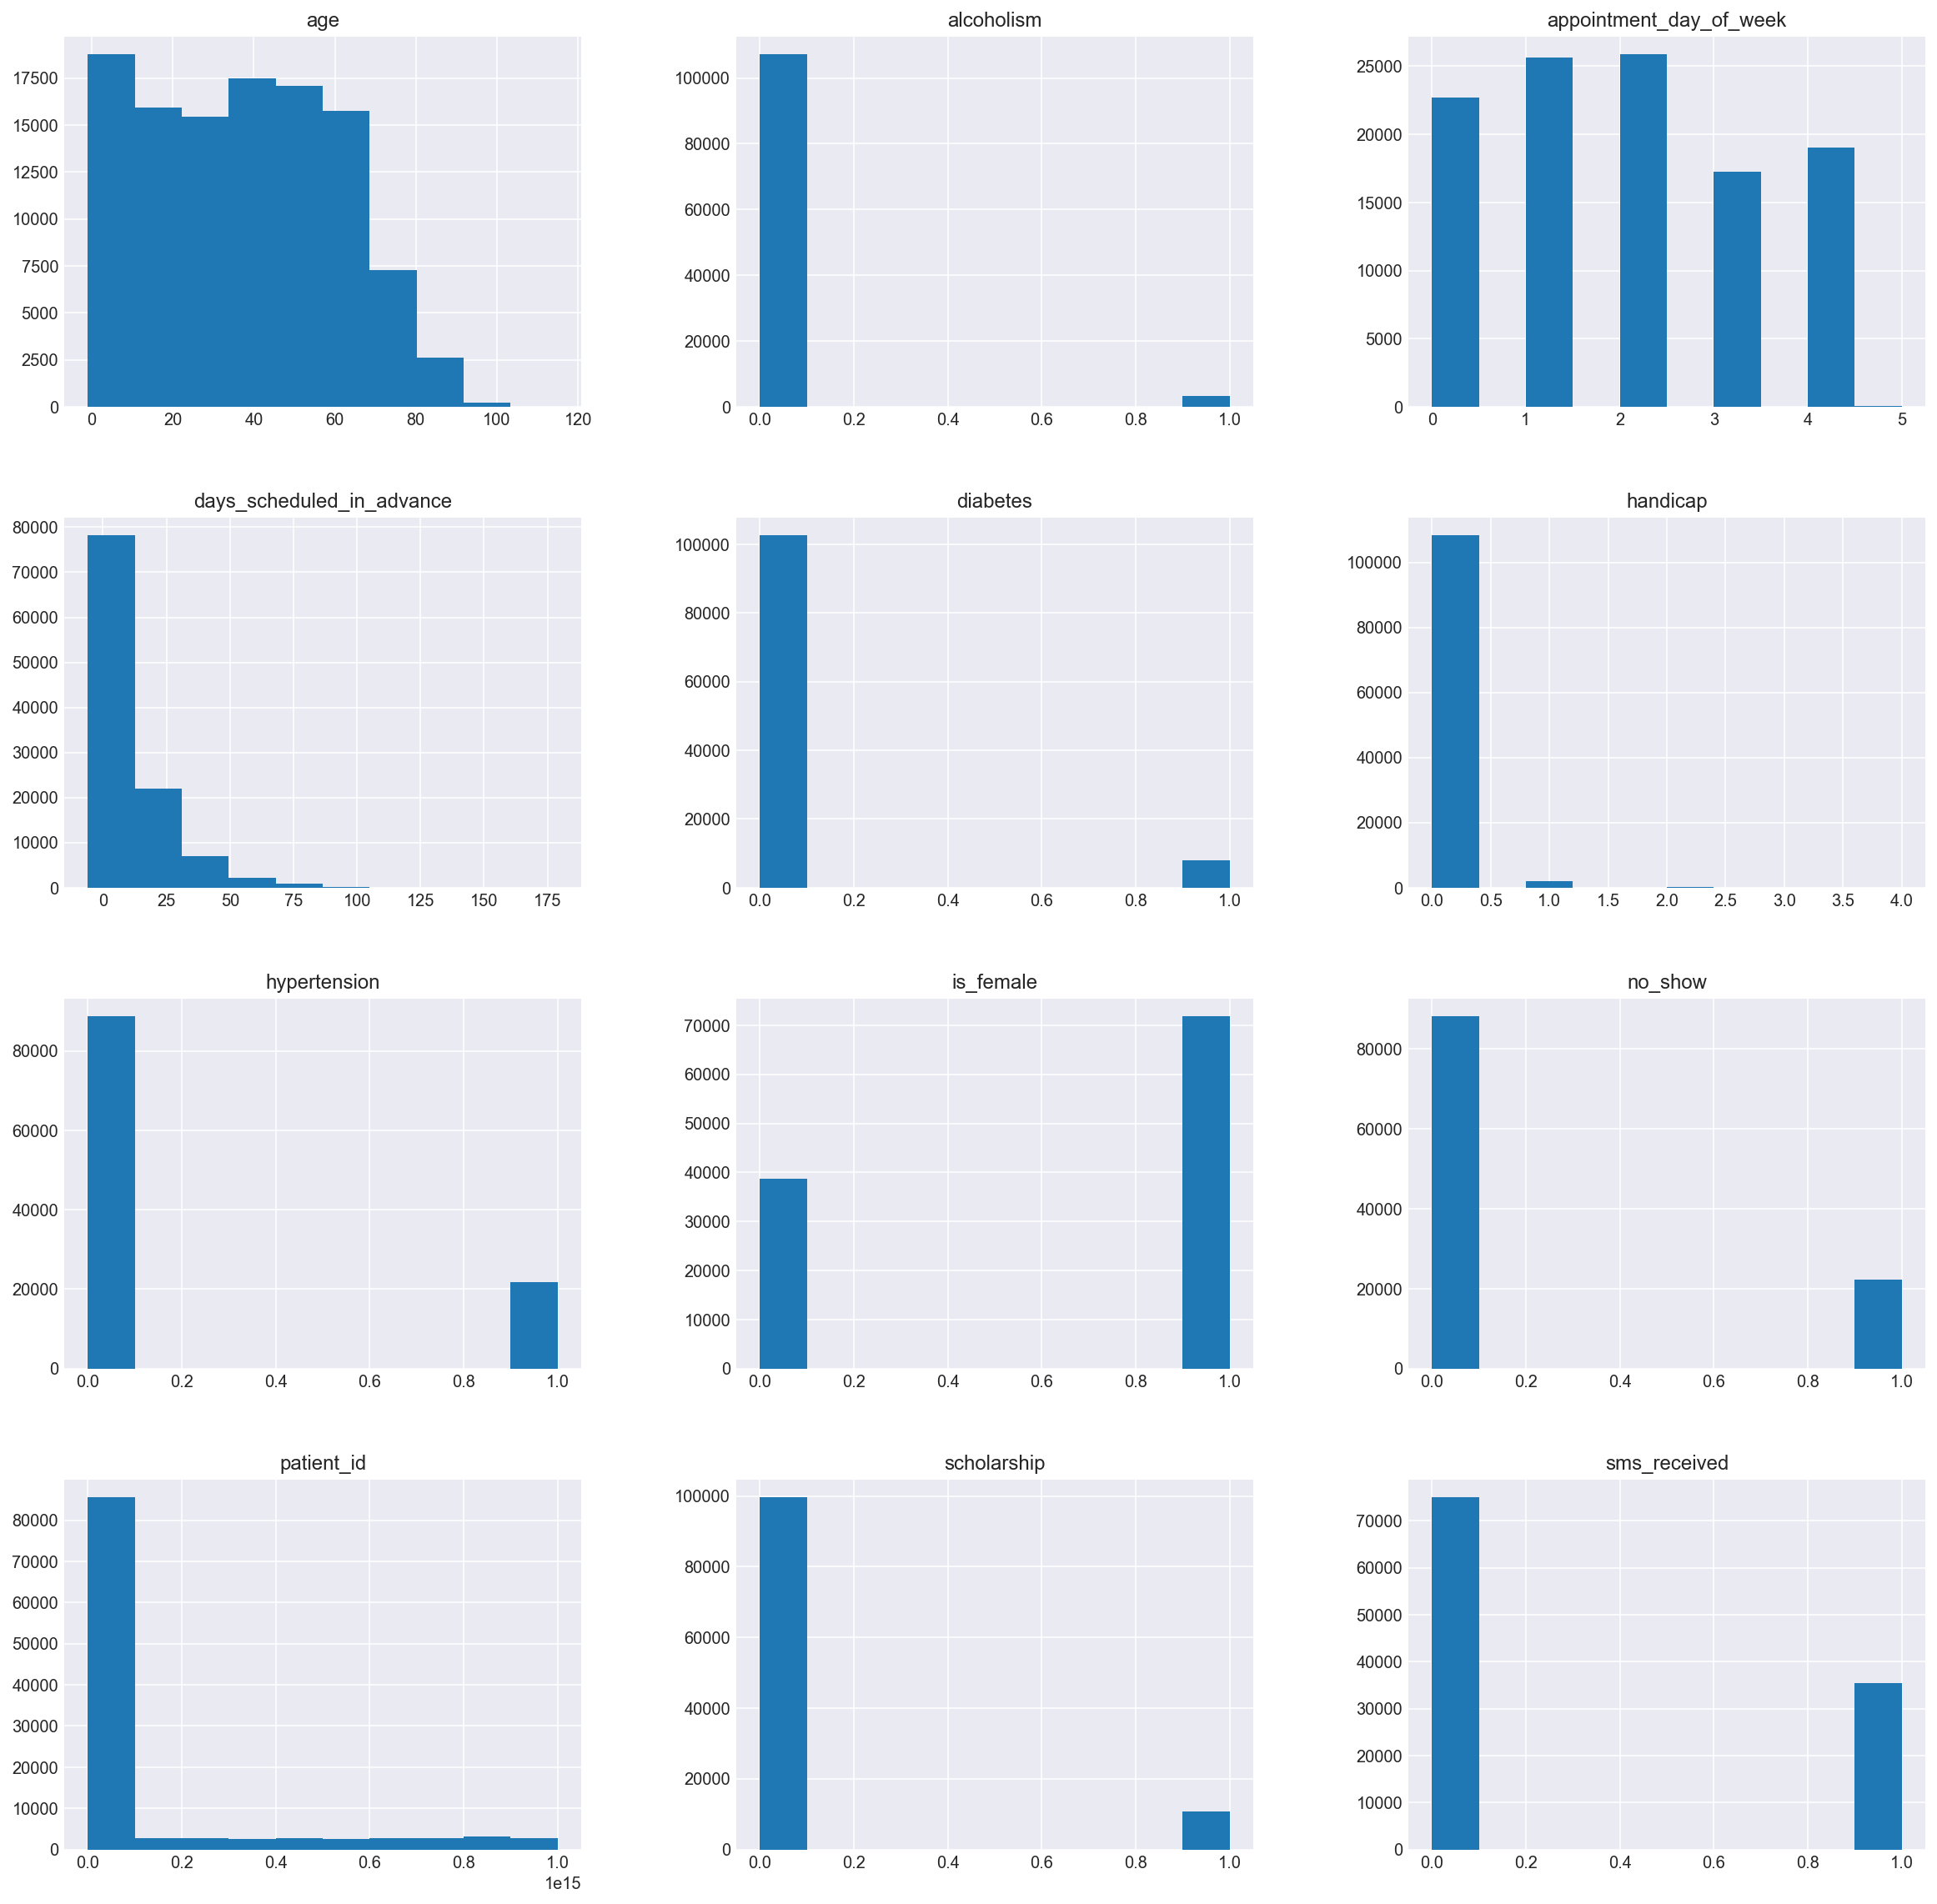

In [40]:
df.hist(figsize=(20,20));

The numerical columns- age and days scheduled in advance appeared to be skewed right. There are more women than men in the sample set and more people seem to have made it to the appointment overall and the trend of more False cases than True is seen across multiple columns, which might suggest a correlation with the no_show numbers. We will investigate the relationships between no_show and a variety of these independent variables by plotting them on a bar graph.

Before that, lets plot the scatter matrix to look for correlation among our presumed independent variables.

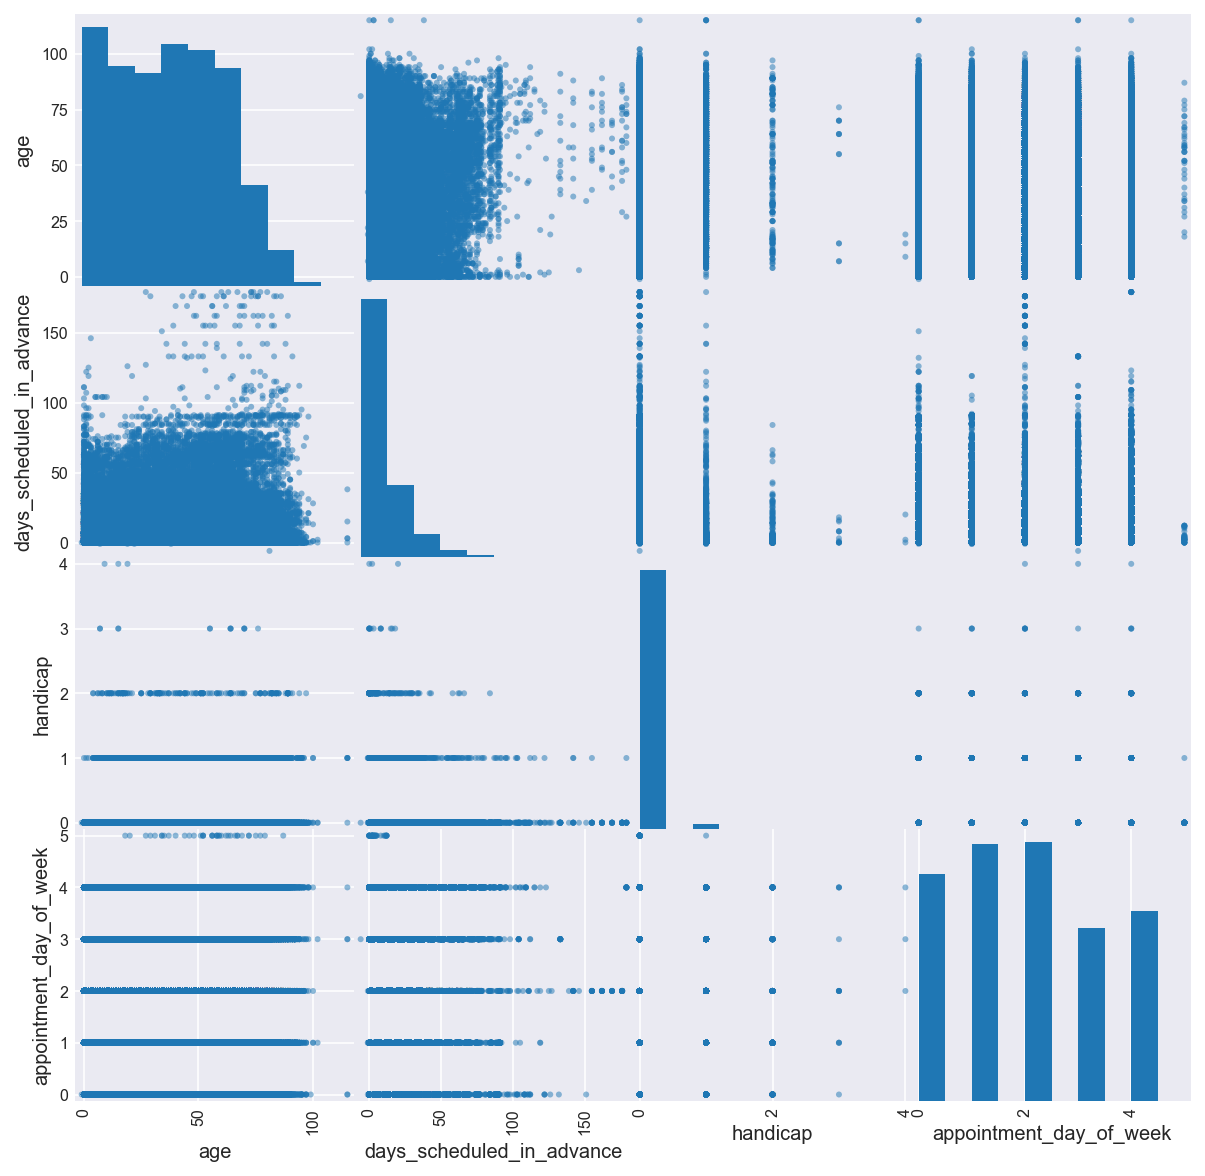

In [41]:
pd.plotting.scatter_matrix(df[['age', 'days_scheduled_in_advance', 'handicap', 'appointment_day_of_week']], figsize=(10,10));

The interesting correlations we see here is that as the disability level increases, the patients are more likely to schedule/get appointments nearer into the future, which is along expected lines.

### Q1) What are the factors that most correlate the most with an appointment being show/no-show?

In [42]:
df.columns


Index(['patient_id', 'scheduled_day', 'appointment_day', 'age',
       'neighbourhood', 'scholarship', 'hypertension', 'diabetes',
       'alcoholism', 'handicap', 'sms_received', 'no_show', 'is_female',
       'appointment_day_of_week', 'days_scheduled_in_advance',
       'scheduled_time_frame', 'age_group'],
      dtype='object')

Let's create two masks one for show and one for no-show for ease of analysis

In [43]:
show = df['no_show'] == False
no_show = df['no_show'] == True

In [44]:
percentage_show = df[show].shape[0] * 100 / df.shape[0]
percentage_no_show = 100 - percentage_show

Now, lets look at overall ratio of show and no-show.

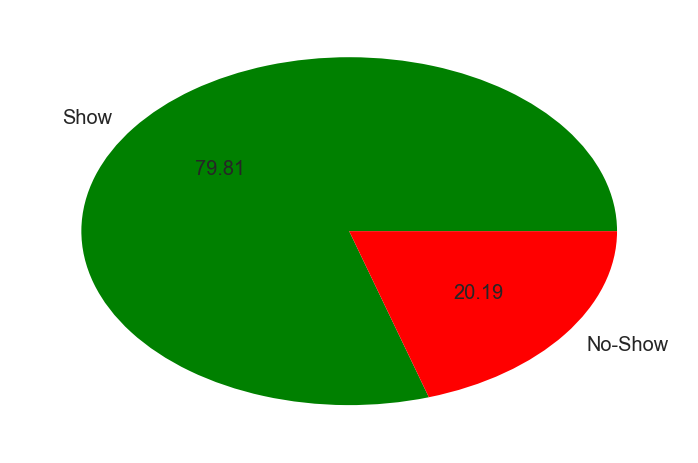

In [45]:
plt.pie([percentage_show, percentage_no_show], labels=['Show', 'No-Show'], colors=['g', 'r'], autopct='%.2f');

We see that in our dataset overall there are ~60% more shows than no shows. We will measure the significance of an independent variable in acting as a predictor for show/no-show based on how it modifies this overall ratio across its various categories.

To do this, we will write a few helper functions below for generating the various types of plots we need for our investigation.

In [46]:
def plot_hist(predictor, target_labels=['show', 'no-show'], target_filters=[show, no_show], target_colors=['g','r']):
    """
    Plot histogram of predictor split by target true and target false cases
    """
    predictor_str = predictor.replace('_', ' ')
    if len(target_labels) != 2 or len(target_filters) != 2:
        print('Only boolean target variables are supported')
        return
    fig, ax = plt.subplots(figsize=(8,6))
    ax.hist(df[target_filters[0]][predictor], alpha=0.5, label=target_labels[0], color=target_colors[0])
    ax.hist(df[target_filters[1]][predictor], alpha=0.5, label=target_labels[1], color=target_colors[1])
    ax.set_title('Distribution of %s/%s over %s' % (target_labels[0], target_labels[1], predictor))
    ax.set_xlabel(predictor_str)
    ax.set_ylabel('value count')
    ax.legend(loc='upper right')
    plt.show();

In [47]:
def plot_1d_bar(predictor, target_label='no_show', color='orangered'):
    """
    Plot 1d bar chart showing percentage of target=True across each category of the predictor
    """
    width=0.8
    predictor_str = predictor.replace('_', ' ')
    no_show_means = df.groupby(predictor)[target_label].mean()
    print(no_show_means)
    no_show_means.plot(kind='bar', width=width, color=color, alpha=0.5)
    plt.title('Probability of %s across %s' % (target_label, predictor))
    plt.xlabel(predictor_str)
    plt.ylabel('probability of %s' % (target_label))
    plt.show();

In [48]:
def plot_2d_bar(bool_predictor1, predictor2, target_label='no_show', predictor1_colors=['orangered', 'b']):
    """
    Plot 2d bar chart showing percentage of target=True for both predictor1=True and predictor1=False across each category of predictor2, 
    """
    width = 0.35 
    (predictor1_str, predictor2_str) = (bool_predictor1.replace('_', ' '), predictor2.replace('_', ' '))
    target_prob = df.groupby([bool_predictor1, predictor2])[target_label].mean()
    print(target_prob)
    predictor2_groups = list(df.groupby(predictor2).groups.keys())
    false_list = []
    true_list = []
    for g in predictor2_groups:
        if g not in target_prob[False]:
            false_list.append(0)
        else:
            false_list.append(target_prob[False][g])            
        if g not in target_prob[True]:
            true_list.append(0)
        else:
            true_list.append(target_prob[True][g])      
    false_ind = np.arange(len(false_list))
    false_bars = plt.bar(false_ind, false_list, width, color=predictor1_colors[0], alpha=0.5, label=predictor1_str + ': False')
    true_bars = plt.bar(false_ind + width, true_list, width, color=predictor1_colors[1], alpha=0.5, label=predictor1_str + ': True')
    plt.title('Probability of %s across %s and %s' % (target_label, bool_predictor1, predictor2))
    plt.xlabel('%s' %(predictor2_str))
    plt.ylabel('probability of %s' % (target_label));
    locations = false_ind + width / 2  # xtick locations
    plt.xticks(locations, predictor2_groups)
    plt.legend()
    plt.show();



##### 1a) Are appointment scheduled nearer in the future more likely to be honored? 

Let's overlay the histogram of days scheduled in advance for show/no-show on top of each other to compare their distributions.

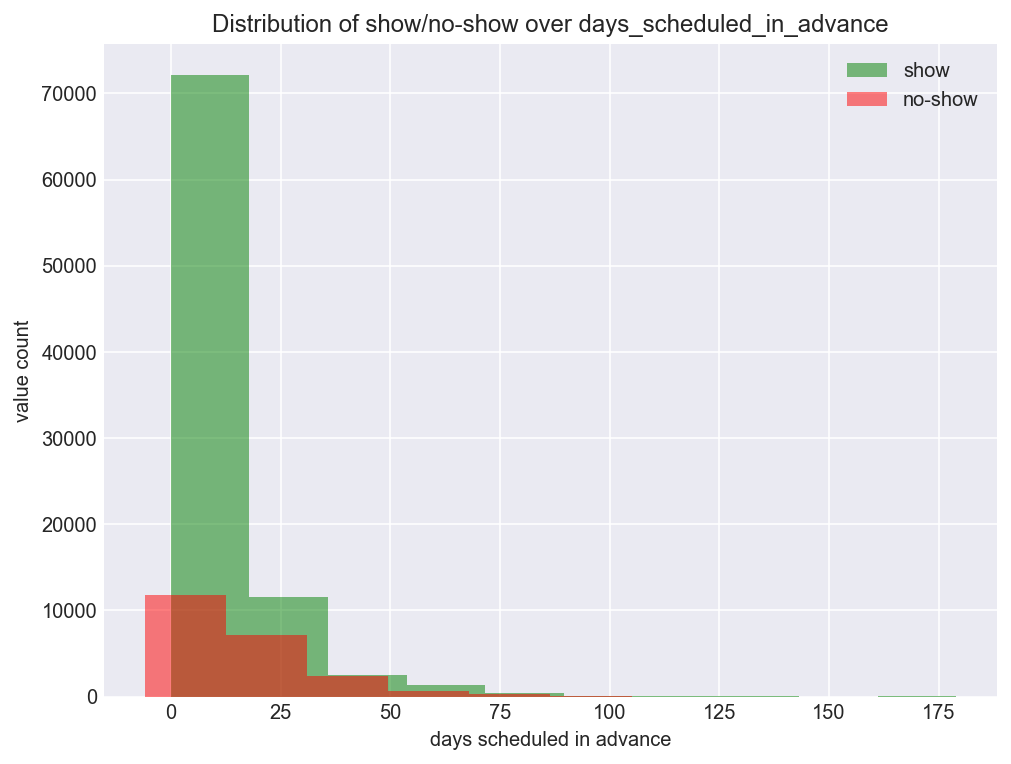

In [49]:
plot_hist('days_scheduled_in_advance')

While overall the number of shows is about 60% higher than number of no shows as we pointed out earlier, the drop in number of shows looks higher than the drop in number of no shows as the time frame increases. Let's compare the mean days scheduled in advance for the two categories.

In [50]:
print(df[show]['days_scheduled_in_advance'].mean(), df[no_show]['days_scheduled_in_advance'].mean())

8.754659441320515 15.83148886598862


Indeed, the average days scheduled in advance is higher for the no_show category than the mean for the show category. Finally, we look at the actual probability of no_show across different categories of `scheduled_time_frame` to find the increase in likelihood of no_show.

scheduled_time_frame
na            1.000000
same_day      0.046469
same_week     0.241479
same_month    0.317447
long_term     0.330208
Name: no_show, dtype: float64


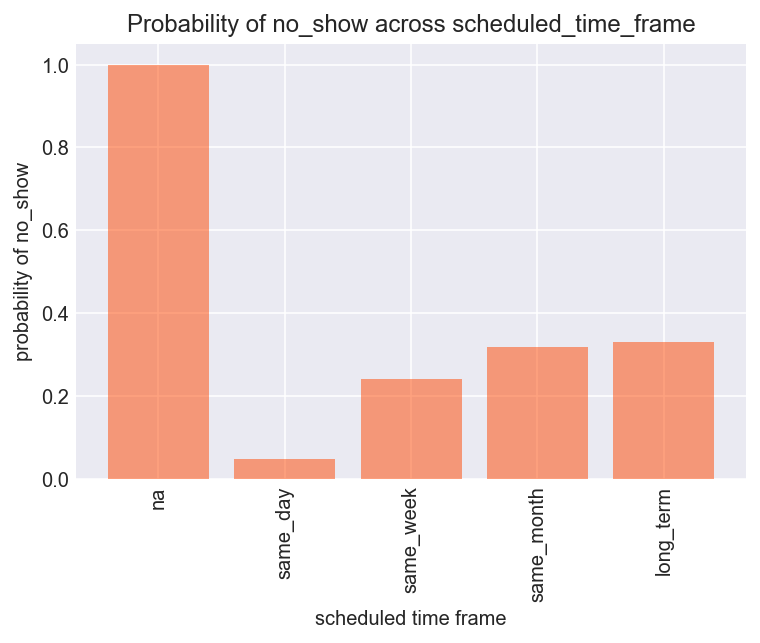

In [51]:
plot_1d_bar('scheduled_time_frame')

The na category which was created for the negative days in advance, which always results in no_show (possibly indicating a scheduling error). For the other categories, the probability is very low for same day appointments to end up as no_shows and it gradually increases as the time horizon increases. So appointments scheduled in nearer future are less likely to end up as no-shows.

##### 1b) Are appointments that fall on certain days of the week less likely to be honored?  

We saw from the histogram earlier than the number of appointments on Saturdays was much lower than the other days. Let's plot it again, splitting it by show / no-show.

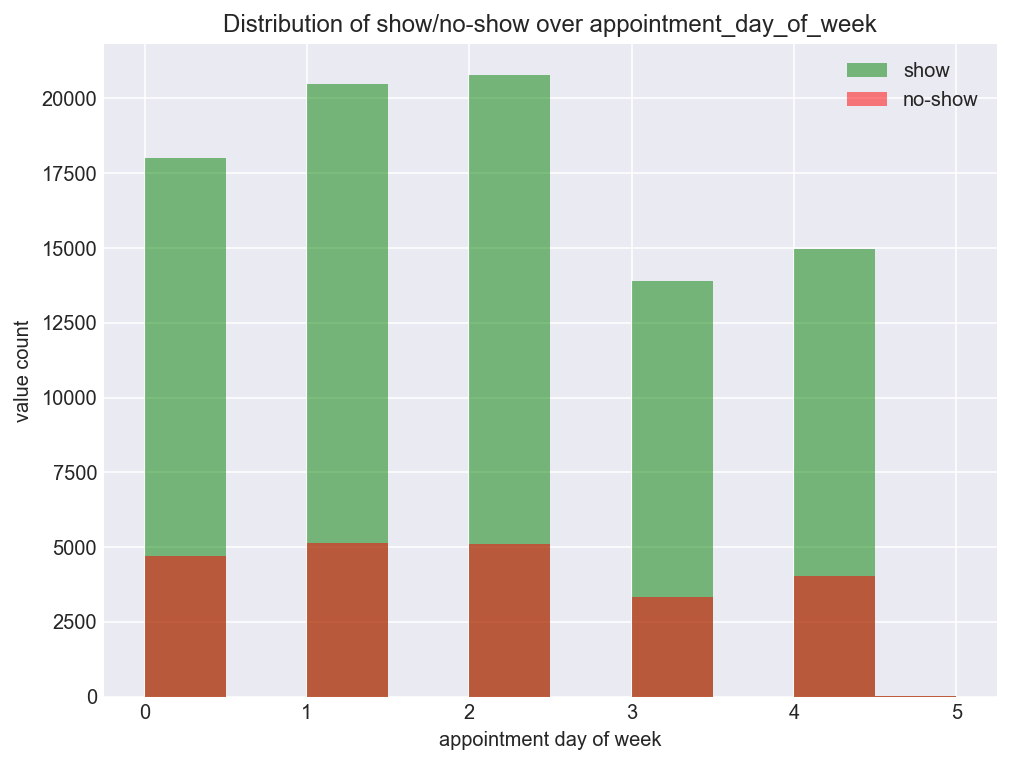

In [52]:
plot_hist('appointment_day_of_week')

The relative trends of show and no-show across days appear similar. Let's look at the probability of no_show for each day of the week to confirm.

appointment_day_of_week
0    0.206471
1    0.200936
2    0.196892
3    0.193541
4    0.212261
5    0.230769
Name: no_show, dtype: float64


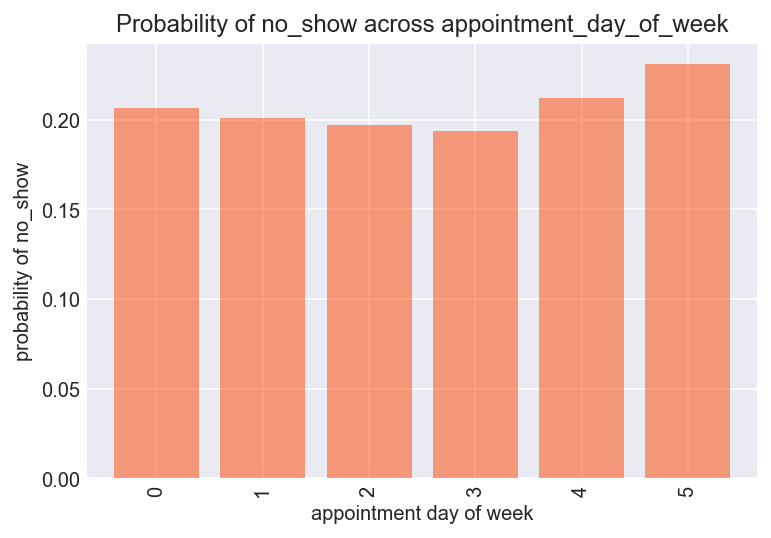

In [53]:
plot_1d_bar('appointment_day_of_week')

We see that there is no strong correlation between day of the week and chances of no_show despite the fact that Tuesdays/Wednesdays are much busier than Saturdays.

##### 1c) Patients of which gender are more likely to keep the appointment?

We saw that overall there are more female patients than male. Let's plot the distribution of appointments across the two groups split by show/no-show.

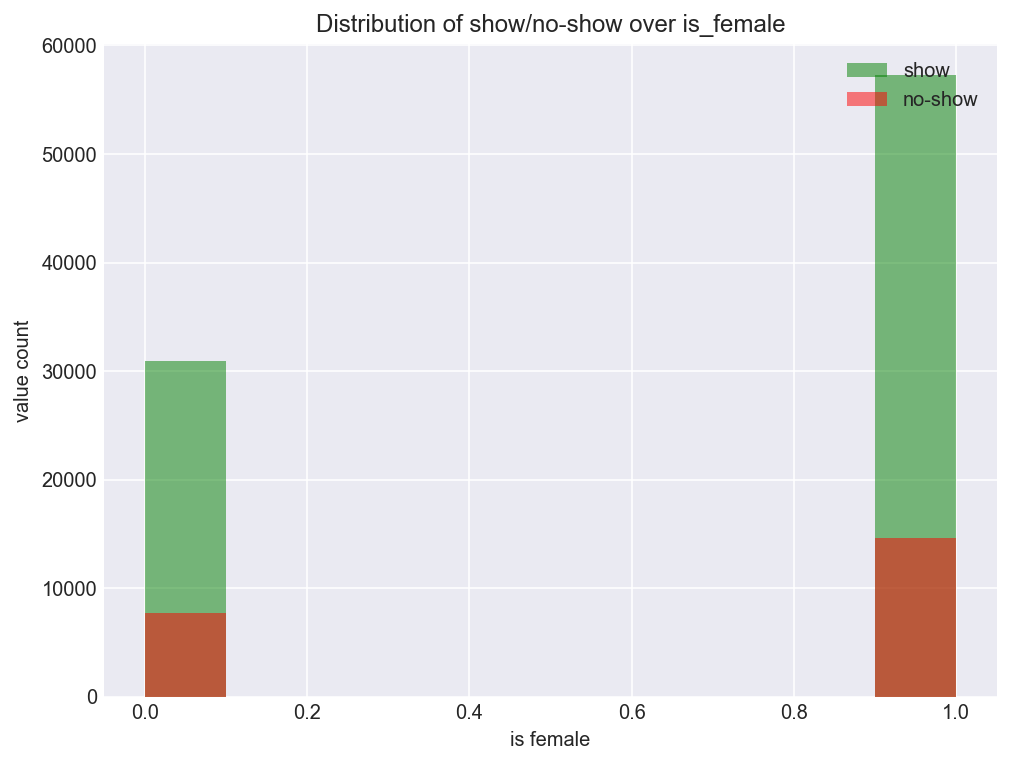

In [54]:
plot_hist('is_female')

Now, let's look at the probability of no-show for the two genders.    

is_female
False    0.199679
True     0.203146
Name: no_show, dtype: float64


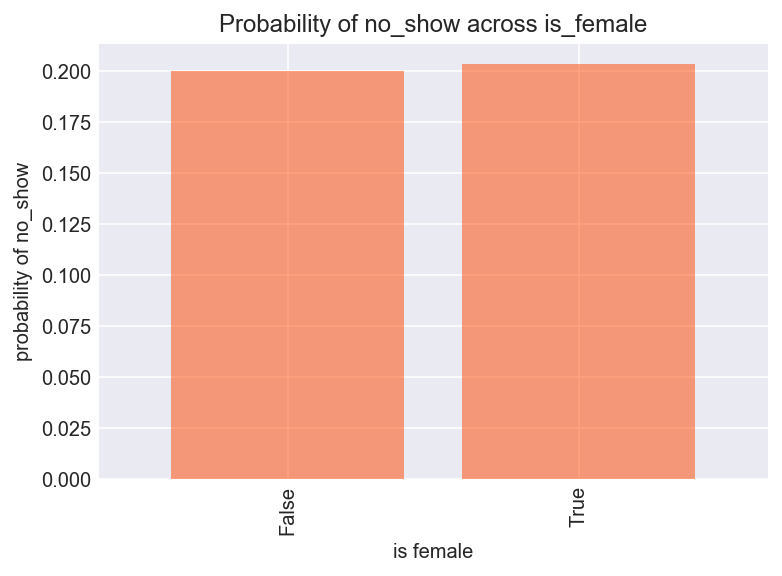

In [55]:
plot_1d_bar('is_female')

Clearly, there is no correlation between gender and show/no-show as they're both about 20% likely to have no_shows.

##### 1d) Patients of which age-group are more likely to keep the appointment? 

We noted from the histogram earlier than overall patients seem to be distributed nicely in the 0-70 age group.

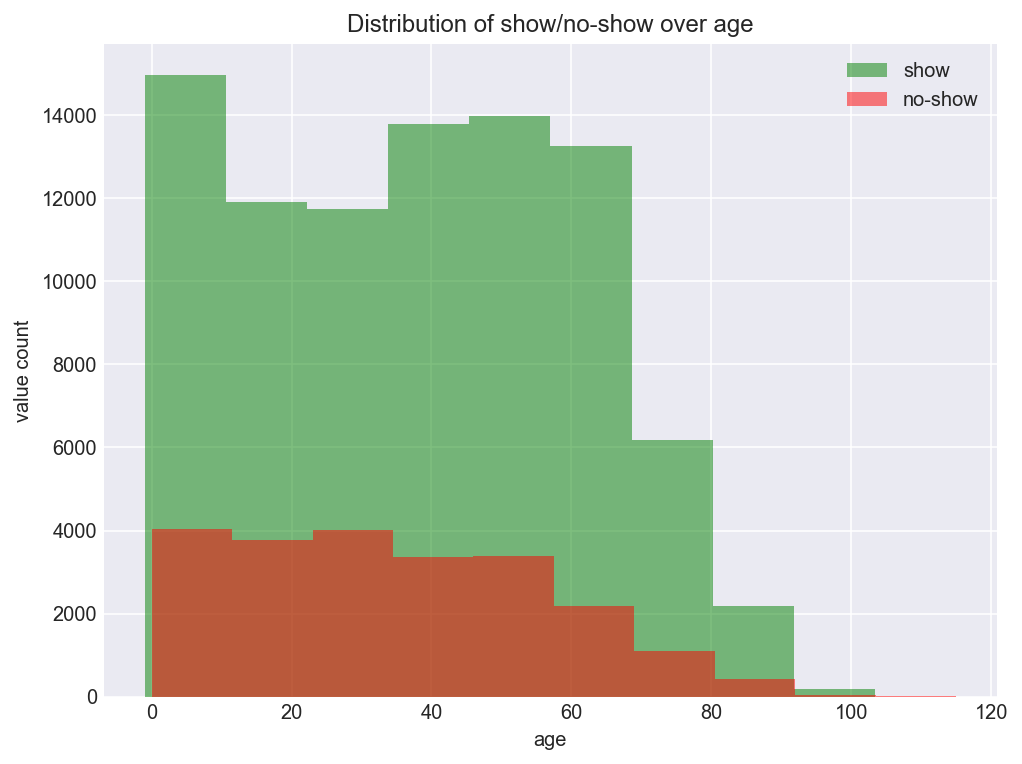

In [56]:
plot_hist('age')

This trend seems to be true for both shows and no-shows.

age_group
Below Zero    0.000000
0-10          0.199371
10-20         0.251778
20-30         0.246733
30-40         0.217520
40-50         0.202688
50-60         0.174998
60-70         0.150724
70-80         0.152005
80-90         0.157841
90-100        0.201970
Above 100     0.000000
Name: no_show, dtype: float64


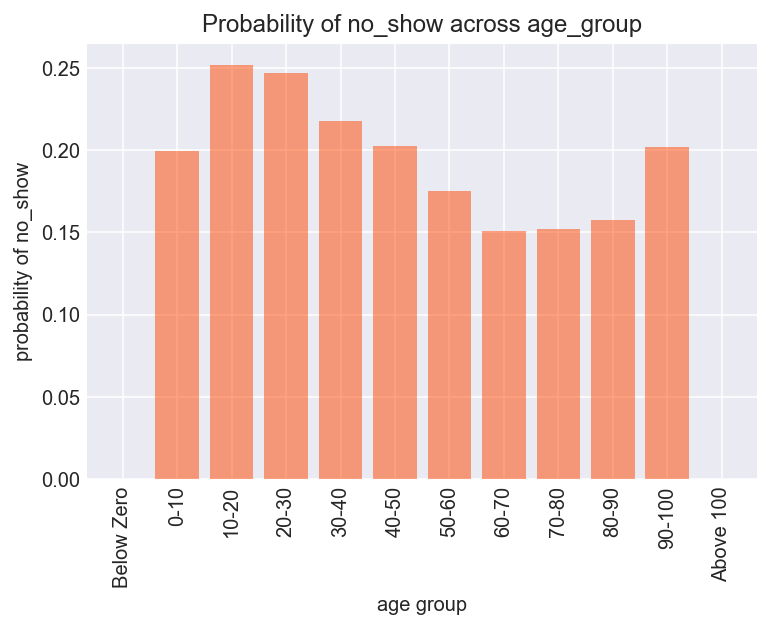

In [57]:
plot_1d_bar('age_group')

In [58]:
df[show]['age'].describe()

count    88208.000000
mean        37.790064
std         23.338878
min         -1.000000
25%         18.000000
50%         38.000000
75%         56.000000
max        115.000000
Name: age, dtype: float64

In [59]:
df[no_show]['age'].describe()

count    22319.000000
mean        34.317667
std         21.965941
min          0.000000
25%         16.000000
50%         33.000000
75%         51.000000
max        115.000000
Name: age, dtype: float64

There doesn't appear to be a strong correlation between age-group and show/ no-show. The dip in no-show is only about 4% in the 60-80 range compared to the age-group that accounts for bulk of the appointments. The average age of patient is in mid 30's for both show and no-show categories.

##### 1e) Which health condition impedes the chances of keeping the appointment? 

Let's plot the probability of no-show for each of the health factors.

In [60]:
df.columns

Index(['patient_id', 'scheduled_day', 'appointment_day', 'age',
       'neighbourhood', 'scholarship', 'hypertension', 'diabetes',
       'alcoholism', 'handicap', 'sms_received', 'no_show', 'is_female',
       'appointment_day_of_week', 'days_scheduled_in_advance',
       'scheduled_time_frame', 'age_group'],
      dtype='object')

###### handicap

handicap
0    0.202353
1    0.179236
2    0.202186
3    0.230769
4    0.333333
Name: no_show, dtype: float64


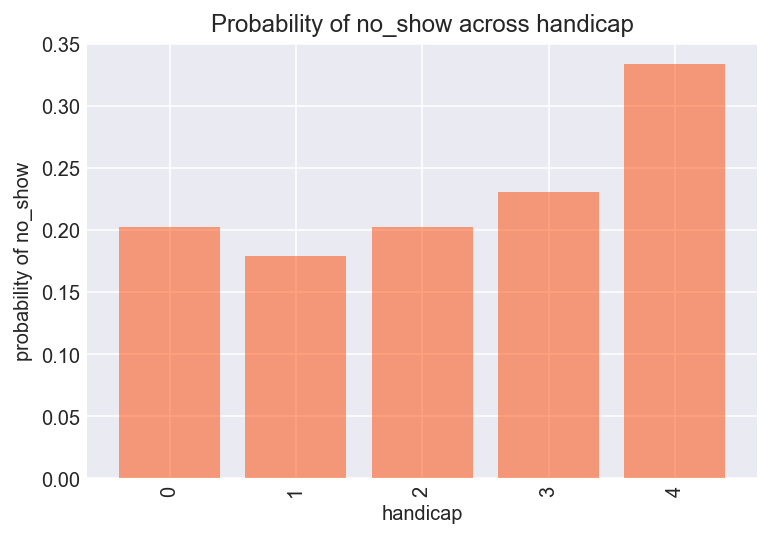

In [61]:
plot_1d_bar('handicap')

As we would have anticipated, the most advanced handicap level has a ~10% higher chance of the appointment ending up as a no_show.

###### hypertension, diabetes, alcoholism

hypertension
False    0.209037
True     0.173020
Name: no_show, dtype: float64


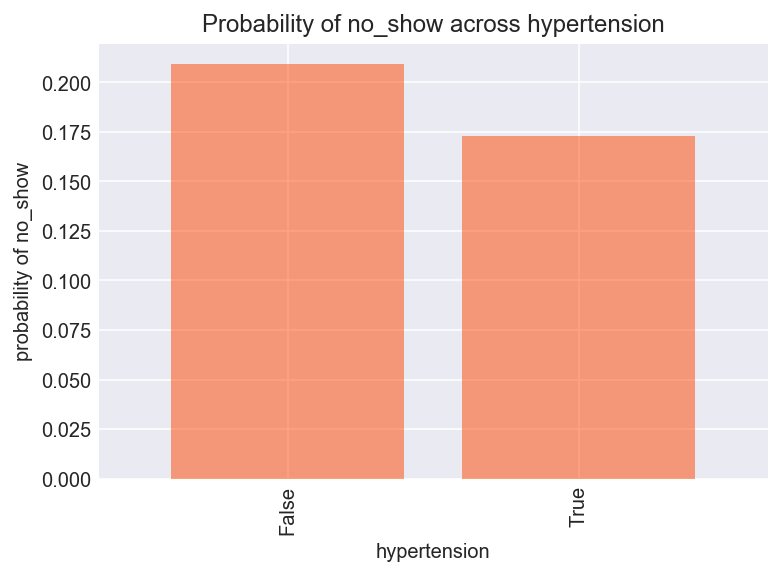

diabetes
False    0.203628
True     0.180033
Name: no_show, dtype: float64


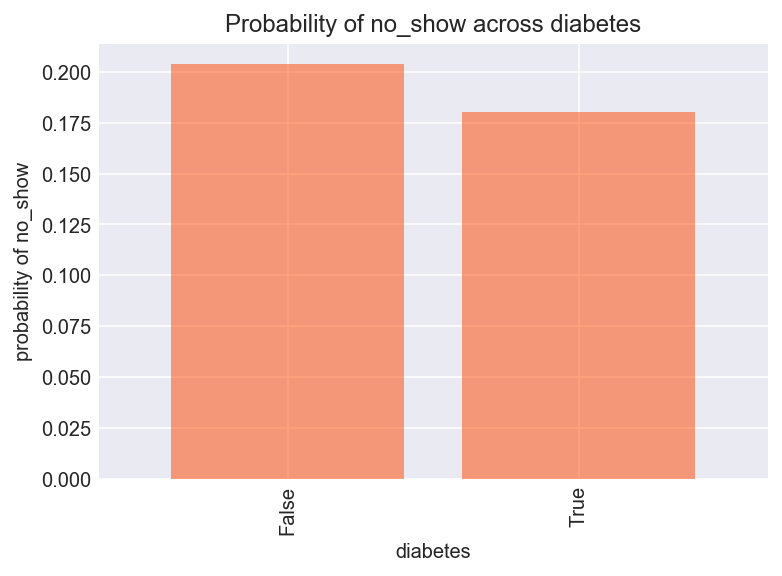

alcoholism
False    0.201946
True     0.201488
Name: no_show, dtype: float64


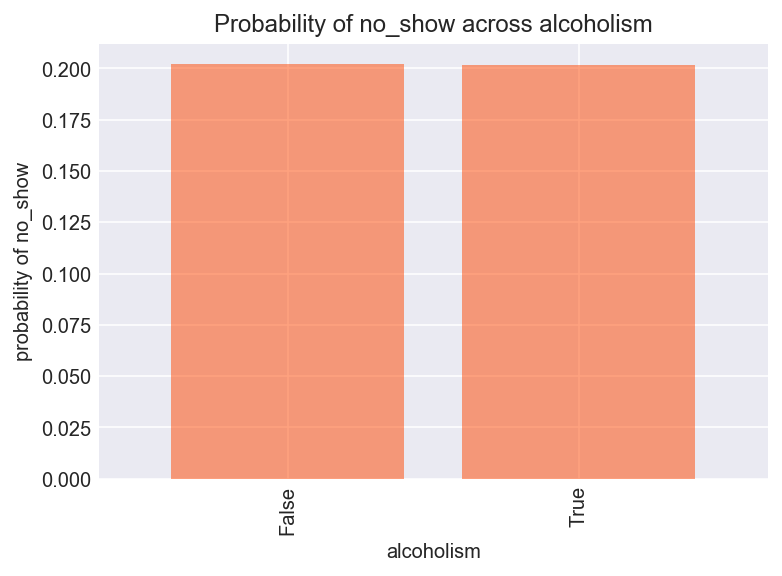

In [62]:
for health_factor in ['hypertension', 'diabetes', 'alcoholism']:
    plot_1d_bar(health_factor)

Alcoholism seems to bear no-correlation to no-show. For diabetes, and hypertension, patients with those health conditions seem to be more likely to honor the appointment but only by a 2-3% lower no-show rate.

### Q2) Do SMS reminders help increase the chances of patients showing up for appointment?

Let's look at how many of the appoinments received sms alerts.

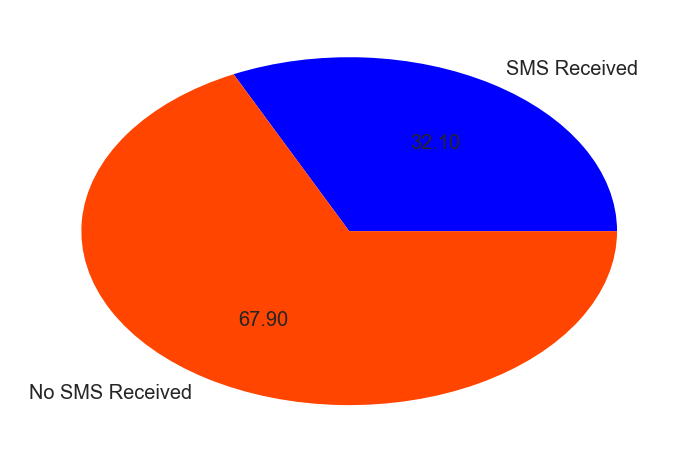

In [63]:
sms_received = df['sms_received'] == True
no_sms_received = df['sms_received'] == False
percentage_received = df[sms_received].shape[0] * 100 / df.shape[0]
plt.pie([percentage_received, 100- percentage_received], labels=['SMS Received', 'No SMS Received'], colors=['b', 'orangered'], autopct='%.2f');

There appears to have been some groups that were targetted for SMS alerts since only 30% of the appointments received alerts. Let's see if overall this targetting strategy was accurate and if the no-show rate is better overall for the sms_received case.

sms_received
False    0.167033
True     0.275745
Name: no_show, dtype: float64


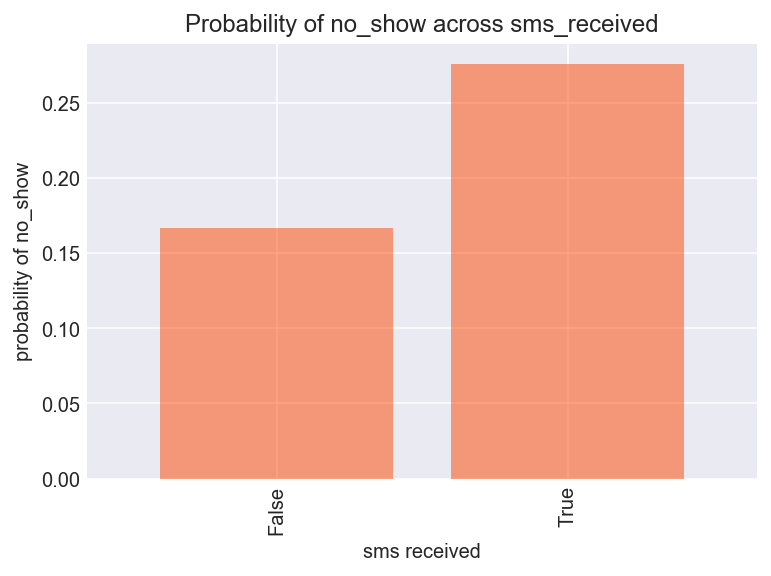

In [64]:
plot_1d_bar('sms_received')

Counterintuitively, the no-show probability is higher for sms_received case. This may be a result of coincidence, or sms alerts being targetted at the wrong group. Let's drill down by two of the categories that would make good candidates for targetting sms alerts, and see the impact on each of these.

##### 2a) Do SMS reminders improve the odds for patients who made their appointments much earlier than the date of appointments?  

Let's revisit the no_show probability bar chart from Q1 and this time split it further by sms_received vs no sms_received.

sms_received  scheduled_time_frame
False         na                      1.000000
              same_day                0.046469
              same_week               0.243640
              same_month              0.356130
              long_term               0.375034
True          same_week               0.237617
              same_month              0.291054
              long_term               0.303250
Name: no_show, dtype: float64


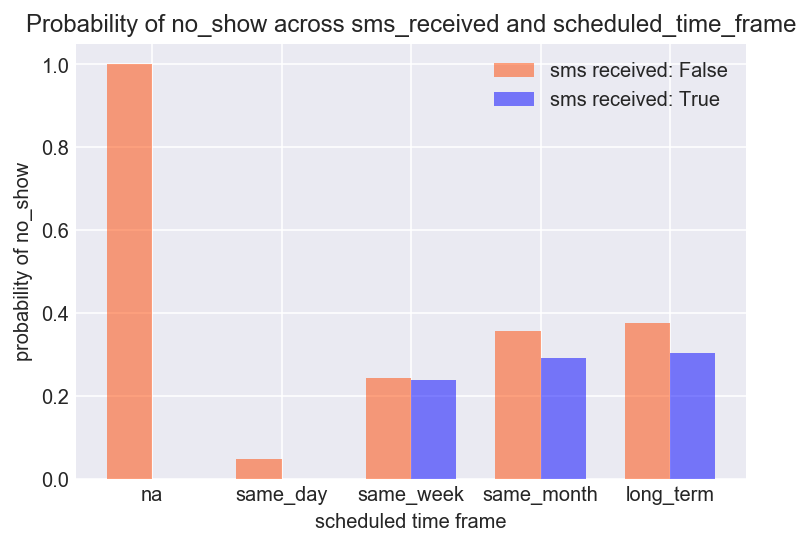

In [65]:
plot_2d_bar('sms_received', 'scheduled_time_frame')

No SMS seem to be sent for same day appointment, which is along expected lines. For same week appointments, the no_show probability is slightly lower for cases where sms was received (by around 1%). For same month category, the drop in no_show improves to upto 6%, i.e. the chances of no_show are 6% lower when SMS is received vs not received. For the long term category, this gap is around 7%. So, clearly SMS received has a greater impact on reducing the no_show probabily for appointments made further out into the future.

Given that we've established that sms_received is important, let's see what the probability of sms_received is for each of the time frames.

scheduled_time_frame
na            0.000000
same_day      0.000000
same_week     0.358801
same_month    0.594419
long_term     0.624459
Name: sms_received, dtype: float64


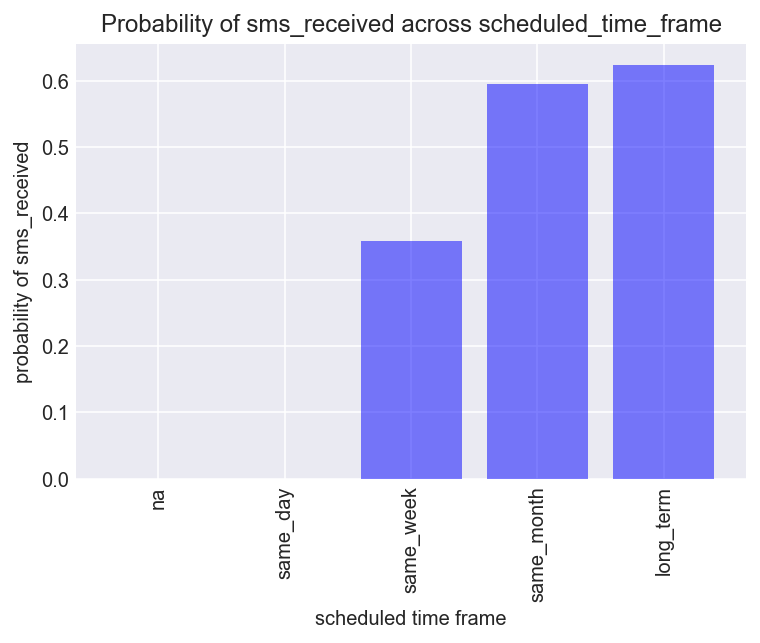

In [66]:
plot_1d_bar('scheduled_time_frame', target_label='sms_received', color='b')

Around 60% of the cases were covered with sms alerts for the same_month and long_term appointments. So, if further experiments are conducted to confirm that this correlation is indeed the result of causation- the general direction of SMS alert targetting is correct, and the no_show count can be brought down by increasing the sms_alert coverage even further.

Overall, SMS reminders do improve the odds for appointments scheduled earlier.

##### 2b) Do SMS reminders improve the odds for older patients? 

Let's split the no_show probability distribution across age-groups from Q1, further by sms received/not received.

sms_received  age_group 
False         Below Zero    0.000000
              0-10          0.163660
              10-20         0.214867
              20-30         0.189922
              30-40         0.170850
              40-50         0.168726
              50-60         0.149481
              60-70         0.133662
              70-80         0.129826
              80-90         0.143644
              90-100        0.186667
              Above 100     0.000000
True          0-10          0.288369
              10-20         0.335352
              20-30         0.353114
              30-40         0.309898
              40-50         0.272259
              50-60         0.225000
              60-70         0.184728
              70-80         0.203352
              80-90         0.198175
              90-100        0.245283
              Above 100     0.000000
Name: no_show, dtype: float64


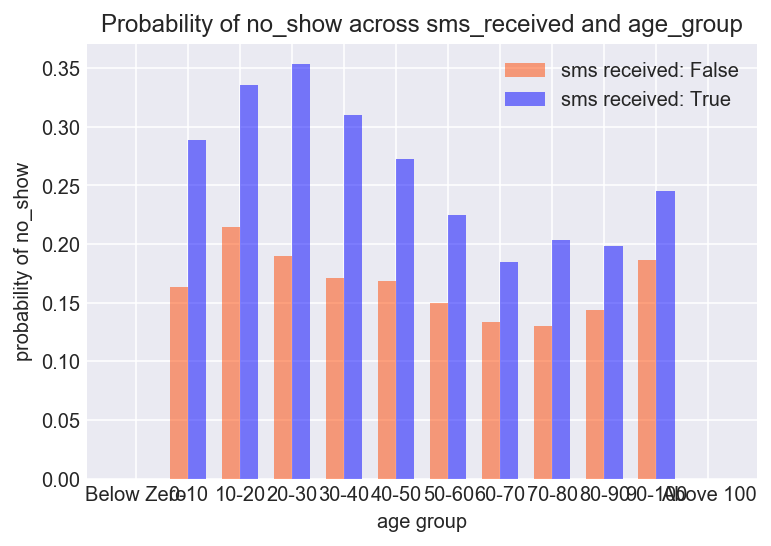

In [67]:
plot_2d_bar('sms_received', 'age_group')

This reflects the overall trend of sms_alerts not being helpful and infact across every age group, the probability of no_show comes out higher for sms_received case. We know that sms alerts aren't likely to deter patients of any age group from showing up for appointment so this is either a coincidence or is a result of missing out some dimensionality in our analysis about nature of people who receive sms alerts across age groups or sms alerts being wasted on groups which would have ended up as no-shows anyway (wrong targetting of alerts).

### Q3) Does Bolsa Familia enrollment have a correlation with the ratio of show/no-show? 

Let's start out by looking at how many of the appoinments below to people who had scholarships.

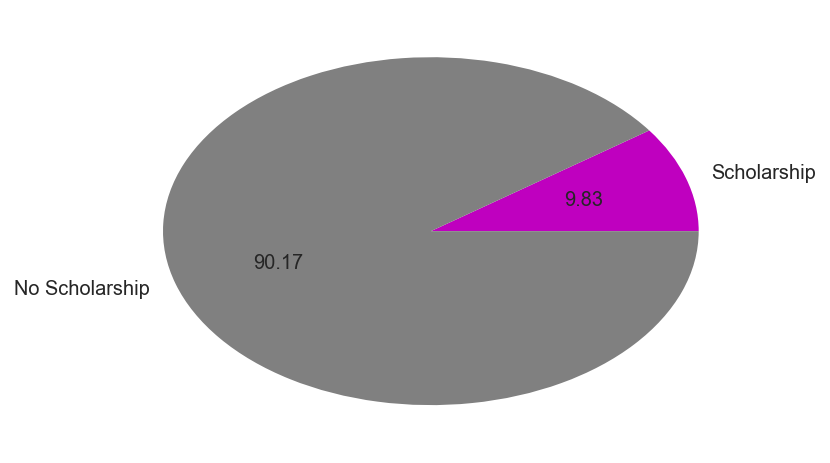

In [68]:
scholarship_received = df['scholarship'] == True
no_scholarship_received = df['scholarship'] == False
percentage_received = df[scholarship_received].shape[0] * 100 / df.shape[0]
plt.pie([percentage_received, 100- percentage_received], labels=['Scholarship', 'No Scholarship'], colors=['m', 'gray'], autopct='%.2f');

Only about 10% of the appointments were made by people who had scholarships. Let's look at the probabilty of no_show across the two catergories.

scholarship
False    0.198072
True     0.237363
Name: no_show, dtype: float64


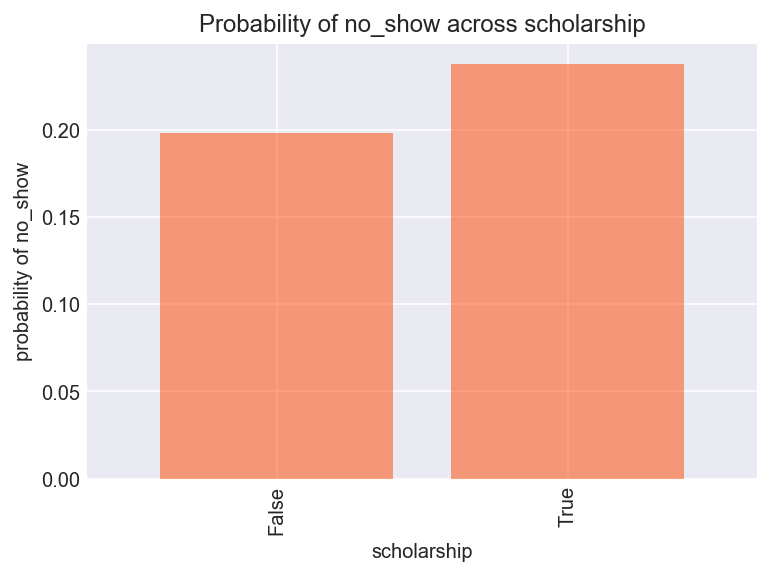

In [69]:
plot_1d_bar('scholarship')

The probability of no_show is higher for cases with scholarship, but this may be due to other factors that make the group targetted for scholarship more prone to no-shows than the other group.

Hence, while having Bolsa Familia doesn't improve the chances of show vs no-show, it could be used as an indicator of patients who might have other impediments to showing up for appoinments such as access to transportation etc.

<a id='conclusions'></a>
## Conclusions

The primary methodology of investigated used for this analysis is to compare the ratio of show/no-show across various categories for one or do dependent variables. This represents a limitation, in that the limit on dimensionality prevents us from being able to make accurate predictions about show/no-show and its useful stops with summarization and hypothesis building for most variables.

The other limitation is that the dataset has anamolous datapoints for age, patient ID, and days scheduled in advance, which are not explained, and hence cannot be fixed. They may not have skewed our analysis because of their small scale, but for a continuously growing dataset it would be important to fix all data consistency issues.

  
Finally, the dataset could have been improved by collecting more metrics such as income level.

With this said, below are the answers to the questions we set out to investigate.

1) What are the factors that most correlate with an appointment ending up as show/no-show?  
    1a) Are appointment scheduled nearer in the future more likely to be honored?  
    `Ans:` Yes.Same day appoints have a ~4% chance of no-show whereas this grows to upto 30% for long term appointments.     
    1b) Are appointments that fall on certain days of the week less likely to be honored?   
    `Ans`: No. There is no such correlation with the day the appointment falls on.      
    1c) Patients of which gender are more likely to keep the appointment?    
    `Ans`: Both genders are equally likely to make it to an appointment.    
    1d) Patients of which age-group are more likely to keep the appointment?    
    `Ans`: There is no strong correlatio between age-group and no-show.    
    1e) Which health condition impedes the chances of keeping the appointment?    
    `Ans` : Disability level 4 has a higher chance of no-show compared to other cases. Hypertension and diabetes seem to make patients sliglty less likely to skip the appointment. Alcoholism has no correlation to show/no-show.  
      
2) Do SMS reminders help increase the chances of patients showing up for appointment?    
    `Ans`: Overall SMS reminders appear to be wasted on groups that were going to end up as no-shows anyway.      
    2a) Do SMS reminders improve the odds for patients who made their appointments much earlier than the date of appointments?    
    `Ans`: Yes, there is a strong correlation here. The targetting by time to appointment is done correctly and for longer timeframes, there is a improvement in show proportion when sms is received.  
    2b) Do SMS reminders improve the odds for older patients?    
    `Ans`: No. Infact across the age, the category with sms_alerts seem to have higher proclivity for no-show which may result of sms alerts not working to improve the odds of cases that they targetted and were at high risk of no-show anyway.  
      
3) Does Bolsa Familia enrollment have a correlation with the ratio of show/no-show?    
    `Ans`: Bolsa Familia group has higher percentage of no-show than the regular group and may indicate that the group, presumably economically disadvantaged in the first place, has other hurdles that may prevent them from making it to appointment sometimes.   
      
    
The strongest correlation of show/no-show seems to be with the time elapsed since scheduling, and sms alerts definitely seem to help bring down the no-show numbers for appointments scheduled early on.
